# **Movies Recommendation System**

## Business Understanding

In today's streaming industry, companies like Netflix, Hulu, and Amazon Prime Video face the challenge of providing users with relevant content that matches their preferences. With vast movie catalogs, it can be overwhelming for users to find films they enjoy, leading to lower engagement and subscription cancellations. 

 An intelligent movie recommendation system can help users discover films that match their tastes, enhancing user satisfaction and platform engagement. This system can boost user retention, increase viewing time, and create personalized experiences, benefiting both users and the platform.

# Problem statement

With the rise of movie streaming platforms  navigating through  collections  of movies and TV shows, users have been overwhelmed in choosing what they want to watch.
The goal is to predict user preferences based on past interactions (such as ratings) and recommend movies they are likely to enjoy. This involves building a collaborative filtering system that leverages user-item interactions, ratings, and predictions to improve user satisfaction by providing accurate and relevant movie suggestions.

# Stakeholders

The primary stakeholders are:

- **Streaming platforms**: They benefit from increased user engagement and retention by offering personalized recommendations.

- **Users**: They receive tailored suggestions, improving their movie-watching experience.

# Objectives

## General Objective

- Build a recommendation system that improves user engagement by providing relevant movie suggestions.


## Specific Objectives

1. To build  a collaborative filtering model  that recommends movies to users based on their previous ratings and the behavior of similar users.

2. To use past user ratings to predict ratings for unrated movies. 

3.  To provide personalized movies recommendations

## Data Understanding

### Data Source
The data for this project comes from the **MovieLens dataset** https://grouplens.org/datasets/movielens/latest/, a widely-used benchmark dataset provided by the GroupLens research group at the University of Minnesota. This dataset is designed specifically for building and testing recommendation systems, making it highly relevant for our project.

We are using the **MovieLens small dataset** (ml-latest-small), which contains:

- **Ratings**: User ratings for different movies.
- **Movies**: Information about movie titles and genres.
- **Tags**: User-generated tags for movies.
- **Links**: Metadata connecting movies to external resources like IMDb.

### Import Libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

In [42]:
pip install surprise

Note: you may need to restart the kernel to use updated packages.


In [43]:
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import numpy as np

### Loading Dataset

In [3]:
# Load the datasets
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
links = pd.read_csv('ml-latest-small/links.csv')


In [5]:
print(ratings.head())
ratings.info()


   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
print(tags.head())
tags.info()

   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [7]:
print(movies.head())
movies.info()

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [8]:
print(links.head())
links.info()

   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [9]:
#merging movies and ratings
merged_df = pd.merge(ratings, movies, on='movieId', how='left')
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


 ### Split Genres
In the original movies.csv file, the genres are provided as a single string with genres separated by the | symbol. This format is not ideal for machine learning models, which work better with categorical variables or separate features.

By converting genres into a list, it becomes easier to:

Use genres for content-based filtering: We can now treat each genre as a separate feature for movies.

Perform analysis on genre popularity: We can count how many times each genre appears across the dataset.

In [12]:
# Split genres into a list of genres for each movie
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

In [15]:
# Merge tags into the merged_data
tags_agg = tags.groupby('movieId')['tag'].apply(lambda x: '|'.join(x)).reset_index()
df = pd.merge(merged_df, tags_agg, on='movieId', how='left')

In [16]:
df.head()

,userId,movieId,rating,timestamp,title,genres,tag_x,tag_y
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar|pixar|fun,pixar|pixar|fun
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,moldy|old,moldy|old
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN,NaN
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,mystery|twist ending|serial killer,mystery|twist ending|serial killer
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,mindfuck|suspense|thriller|tricky|twist ending...,mindfuck|suspense|thriller|tricky|twist ending...


In [20]:
# Data shapes
print("Movies Shape:", movies.shape)
print("Ratings Shape:", ratings.shape)
print("Tags Shape:", tags.shape)
print("Links Shape:", links.shape)
print("\n-----------------------------------------------\n")

# Get info on datasets
print("\nMovies Info:\n", df.info())


Movies Shape: (9742, 3)
Ratings Shape: (100836, 4)
Tags Shape: (3683, 4)
Links Shape: (9742, 3)

-----------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
 6   tag_x      48287 non-null   object 
 7   tag_y      48287 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 6.9+ MB

Movies Info:
 None


### Observation
- There are 100K+ records in the data. 
- There seven features which are ; userId, movieId, rating,  timestamp, title, genres, tag_x  and tag_y.

## Exploratory Data Analysis

In [21]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [27]:
df.isna().sum()

userId           0
movieId          0
rating           0
timestamp        0
title            0
genres           0
tag_x        52549
tag_y        52549
dtype: int64

This dataset has missing values in the dataframe that could be dropped, filled with other values or ignored altogether based on their importance in our research.

In [28]:
df.duplicated().sum()

0

This dataset has no duplicates.

In [29]:
df.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


# Rating Distribution


Examining how movie ratings are distributed using a histogram.

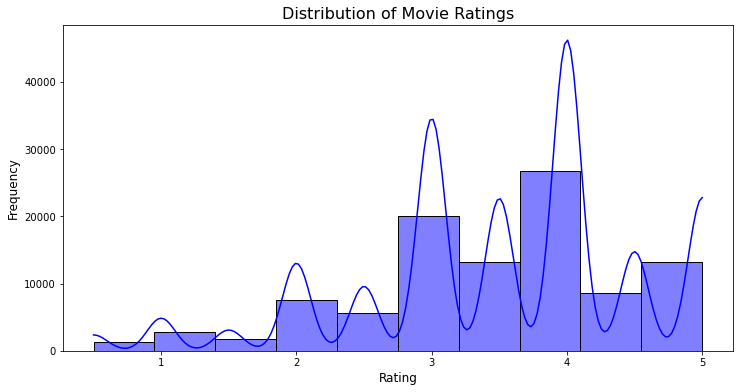

In [33]:
# Plot the distribution of movie ratings
plt.figure(figsize=(12, 6))
sns.histplot(df['rating'], bins=10, kde=True, color='blue')
plt.title('Distribution of Movie Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Rating Distribution by Genre

Analyzing the distribution of ratings for each genre.

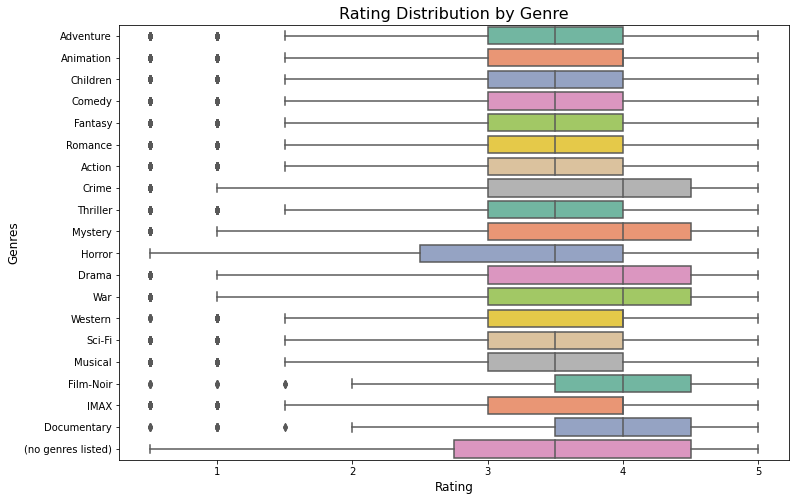

In [35]:
# Explode the genres and assign ratings to each genre
exploded_genres = df[['rating', 'genres']].copy()
exploded_genres = exploded_genres.assign(genres=exploded_genres['genres'].str.split('|')).explode('genres')

# Plot rating distribution for each genre
plt.figure(figsize=(12, 8))
sns.boxplot(x='rating', y='genres', data=exploded_genres, palette='Set2')
plt.title('Rating Distribution by Genre', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Genres', fontsize=12)
plt.show()

# Top 10 Active Users

Identifing users who have rated the most movies.

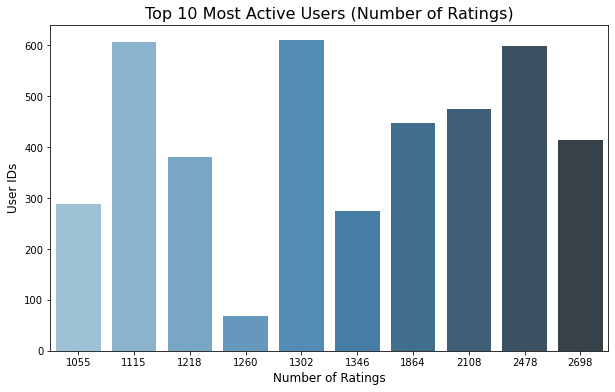

In [36]:
# Count the number of ratings per user
top_users = df['userId'].value_counts().head(10)

# Plot the top 10 active users
plt.figure(figsize=(10, 6))
sns.barplot(x=top_users.values, y=top_users.index, palette='Blues_d')
plt.title('Top 10 Most Active Users (Number of Ratings)', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('User IDs', fontsize=12)
plt.show()

# Most Rated Movies

Identifing which movies have received the most ratings.

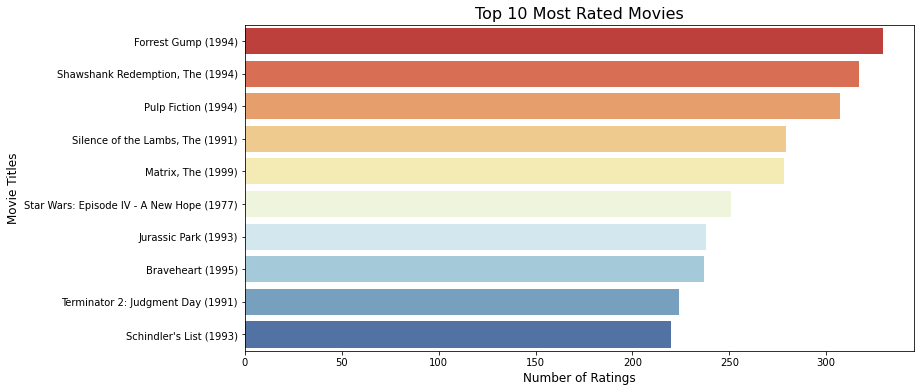

In [37]:
# Count the number of ratings per movie
top_movies = df['title'].value_counts().head(10)

# Plot the top 10 most rated movies
plt.figure(figsize=(12, 6))
sns.barplot(x=top_movies.values, y=top_movies.index, palette='RdYlBu')
plt.title('Top 10 Most Rated Movies', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Movie Titles', fontsize=12)
plt.show()

## Distribution of Ratings Over Time

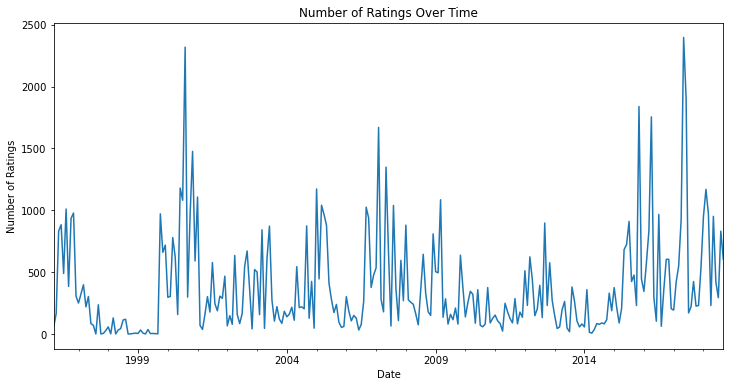

In [39]:
# Convert timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
plt.figure(figsize=(12, 6))
ratings.set_index('timestamp').resample('M').size().plot()
plt.title('Number of Ratings Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.show()

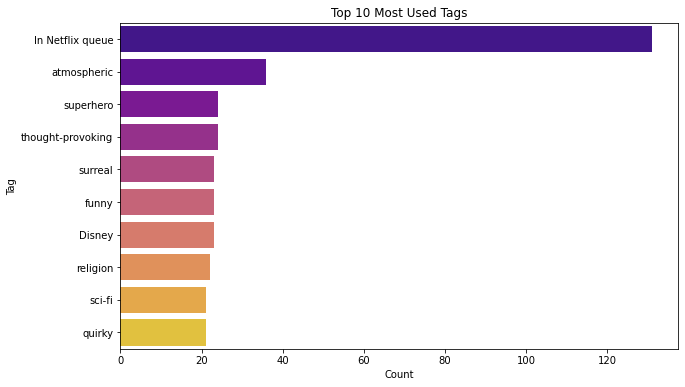

In [64]:
# Count occurrences of each tag
top_tags = tags['tag'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_tags.values, y=top_tags.index, palette='plasma')
plt.title('Top 10 Most Used Tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()

# Creating a utility matrix
A utility matrix is essential for collaborative filtering. Rows will represent users, columns will represent movies, and the values will be the ratings.

In [40]:
# Creating a utility matrix where users are rows, movies are columns, and ratings are values
movie_matrix = df.pivot_table(index='userId', columns='title', values='rating')

# Filling missing ratings with 0 for simplicity (or we could use other imputation methods)
movie_matrix.fillna(0, inplace=True)

# Display the utility matrix
movie_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

Use surprise's built-in reader class to process data to work with recommender algorithms.

In [44]:
from surprise import Reader, Dataset
reader = Reader()

# Ensure the DataFrame has only the necessary columns
df_for_surprise = df[['userId', 'movieId', 'rating']]

# Load the data into Surprise's Dataset object
data = Dataset.load_from_df(df_for_surprise, reader)

We check how many users and items we have in our dataset to determine whether or not we should perform user-user or item-item similarity.

In [45]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


## Baseline Models

In [47]:
knn_basic = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})
knn_basic_results = cross_validate(knn_basic, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print("KNNBasic Results")
print(f"Average RMSE: {knn_basic_results['test_rmse'].mean()}")
print(f"Average MAE: {knn_basic_results['test_mae'].mean()}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9703  0.9815  0.9699  0.9667  0.9659  0.9708  0.0056  
MAE (testset)     0.7482  0.7540  0.7474  0.7430  0.7466  0.7479  0.0036  
Fit time          1.38    1.66    1.96    1.62    1.48    1.62    0.20    
Test time         2.65    2.76    3.42    2.71    2.94    2.90    0.28    
KNNBasic Results
Average RMSE: 0.9708350229438751
Average MAE: 0.7478606299860655


In [48]:
# KNNWithMeans - Adjusted KNN model with mean subtraction
knn_means = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True})
knn_means_results = cross_validate(knn_means, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print("\nKNNWithMeans Results")
print(f"Average RMSE: {knn_means_results['test_rmse'].mean()}")
print(f"Average MAE: {knn_means_results['test_mae'].mean()}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9029  0.9078  0.8972  0.9041  0.8890  0.9002  0.0065  
MAE (testset)     0.6905  0.6946  0.6862  0.6943  0.6788  0.6889  0.0059  
Fit time          2.01    1.76    1.23    1.17    1.21    1.48    0.34    
Test time         5.15    3.25    2.68    2.85    3.06    3.40    0.90    

KNNWithMeans Results
Average RMSE: 0.9001913074966014
Average MAE: 0.6888833108919924


In [49]:
# KNNBaseline - KNN with baseline ratings
knn_baseline = KNNBaseline(sim_options={'name': 'cosine', 'user_based': True})
knn_baseline_results = cross_validate(knn_baseline, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print("\nKNNBaseline Results")
print(f"Average RMSE: {knn_baseline_results['test_rmse'].mean()}")
print(f"Average MAE: {knn_baseline_results['test_mae'].mean()}")

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8823  0.8803  0.8795  0.8702  0.8736  0.8772  0.0045  
MAE (testset)     0.6767  0.6743  0.6704  0.6656  0.6699  0.6714  0.0038  
Fit time          2.11    2.34    3.01    2.31    2.00    2.36    0.35    
Test time         3.61    3.99    5.65    3.30    3.81    4.07    0.82    

KNNBaseline Results
Average

In [50]:
# Initialize the SVD model
svd = SVD()
# Perform cross-validation on the dataset
svd_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print("SVD Results")
print(f"Average RMSE: {svd_results['test_rmse'].mean()}")
print(f"Average MAE: {svd_results['test_mae'].mean()}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8700  0.8826  0.8761  0.8691  0.8751  0.8746  0.0049  
MAE (testset)     0.6694  0.6758  0.6735  0.6696  0.6719  0.6720  0.0024  
Fit time          8.33    8.80    9.46    7.68    9.13    8.68    0.62    
Test time         0.26    0.34    0.29    0.26    0.29    0.29    0.03    
SVD Results
Average RMSE: 0.8745866691589977
Average MAE: 0.6720313019418394


SVD performs the best with the lowest RMSE of 0.8746, indicating it has the most accurate predictions in terms of minimizing error.
KNNBaseline is a close second with an RMSE of 0.8772, which is still very good and competitive with SVD.
KNNWithMeans performs moderately well with an RMSE of 0.9002, better than KNNBasic but worse than the other models.
KNNBasic has the highest RMSE of 0.9708, suggesting it is the least accurate model among the ones compared.

SVD and KNNBaseline are the top-performing models based on RMSE, making them preferable for recommendation tasks.

1. Hybrid Recommendation Approach
Combine Methods: Use a hybrid model that combines collaborative filtering (e.g., KNN, SVD) with content-based filtering. This leverages both user ratings and metadata (tags, genres) for improved accuracy.
Evaluate Performance: Regularly assess the performance of each method and adjust weights in the hybrid model based on empirical results
2. Feature Engineering
Utilize Tags: Incorporate user-generated tags to enrich the content-based filtering component. Analyze tag frequencies and their relationships with genres to create more nuanced features.
Genre Variations: Consider multi-label approaches for genres, as movies can belong to multiple categories. This can enhance the recommendations for users with diverse tastes.
3. Incorporate User Feedback
Feedback Loop: Implement a system to gather user feedback on recommendations (e.g., thumbs up/down, ratings). Use this data to refine models and adapt to changing user preferences.
User Profiles: Build dynamic user profiles that evolve based on user interactions over time.
4. Explore Advanced Algorithms
Deep Learning Models: Experiment with deep learning techniques such as neural collaborative filtering or recurrent neural networks (RNNs) for sequential recommendation.
Matrix Factorization Techniques: Consider advanced matrix factorization methods like Alternating Least Squares (ALS) or Factorization Machines
5. User Segmentation
Segment Users: Analyze user behavior and segment users based on their viewing habits. Tailor recommendations to specific segments (e.g., casual viewers, binge-watchers).
Personalized Experience: Create personalized dashboards for users showcasing recommended movies, recently watched, and popular tags based on their profile.

## Model Tuning

In [51]:
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}

In [52]:
# Initialize GridSearch for KNNBasic
gs_knn_basic = GridSearchCV(KNNBasic, params, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

# Perform the grid search
gs_knn_basic.fit(data)

# Print the best RMSE score and corresponding parameters
print(f"Best RMSE for KNNBasic: {gs_knn_basic.best_score['rmse']}")
print(f"Best parameters for KNNBasic: {gs_knn_basic.best_params['rmse']}")

Best RMSE for KNNBasic: 0.9471156516781367
Best parameters for KNNBasic: {'n_factors': 20, 'reg_all': 0.02}


In [53]:
# Initialize GridSearch for KNNBaseline
gs_knn_baseline = GridSearchCV(KNNBaseline, params, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

# Perform the grid search
gs_knn_baseline.fit(data)

# Print the best RMSE score and corresponding parameters
print(f"Best RMSE for KNNBaseline: {gs_knn_baseline.best_score['rmse']}")
print(f"Best parameters for KNNBaseline: {gs_knn_baseline.best_params['rmse']}")

Best RMSE for KNNBaseline: 0.8748307879584669
Best parameters for KNNBaseline: {'n_factors': 20, 'reg_all': 0.02}


In [65]:
# Initialize GridSearch for KNNWithMeans
gs_knn_means = GridSearchCV(KNNWithMeans, params, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

# Perform the grid search
gs_knn_means.fit(data)

# Print the best RMSE score and corresponding parameters
print(f"Best RMSE for KNNWithMeans: {gs_knn_means.best_score['rmse']}")
print(f"Best parameters for KNNWithMeans: {gs_knn_means.best_params['rmse']}")

Best RMSE for KNNWithMeans: 0.8748307879584669
Best parameters for KNNWithMeans: {'n_factors': 20, 'reg_all': 0.02}


In [55]:
# Initialize GridSearch for SVD
g_s_svd = GridSearchCV(SVD, params, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

# Perform the grid search
g_s_svd.fit(data)

# Print the best RMSE score and corresponding parameters
print(f"Best RMSE for SVD: {g_s_svd.best_score['rmse']}")
print(f"Best parameters for SVD: {g_s_svd.best_params['rmse']}")

Best RMSE for SVD: 0.8696003857581649
Best parameters for SVD: {'n_factors': 100, 'reg_all': 0.05}


After model tuning, SVD performs best with the lowest RMSE of 0.8696 as compared to other models hence best choice to use in our recommendation system. The results indicate that the choice of model and tuning parameters significantly impacts performance. SVD's ability to leverage latent factors appears crucial for achieving better accuracy in this context.

In [66]:
# Build the full trainset with the best parameters
best_params = g_s_svd.best_params
trainset = data.build_full_trainset()

In [67]:
# Get the best parameters for RMSE
best_params = g_s_svd.best_params
print("Best parameters:", best_params)

# Access the best parameters for RMSE
best_rmse_params = best_params['rmse']
print("Best parameters for RMSE:", best_rmse_params)

# Check the structure of best_rmse_params
print("Best RMSE Params Structure:", best_rmse_params)

# Initialize and fit the SVD model with the best parameters
try:
    algo = SVD(
        n_factors=best_rmse_params['n_factors'],   
        reg_all=best_rmse_params['reg_all']
    )
except KeyError as e:
    print(f"Parameter not found: {e}")

# Fit the model on the full trainset
trainset = data.build_full_trainset()
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

# Predicting the ratings for the test set
predictions = algo.test(testset)


Best parameters: {'rmse': {'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_factors': 100, 'reg_all': 0.05}}
Best parameters for RMSE: {'n_factors': 100, 'reg_all': 0.05}
Best RMSE Params Structure: {'n_factors': 100, 'reg_all': 0.05}


In [70]:
from collections import defaultdict
def get_all_predictions(predictions):
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n

# Assuming predictions is already generated from algo.test(testset)
predictions = algo.test(testset)  # Ensure this is executed first
all_pred = get_all_predictions(predictions)  # Get all predictions

# To get top N recommendations
n = 4

# Limit each user's recommendations to the top N
for uid in all_pred.keys():
    all_pred[uid] = all_pred[uid][:n]  # Keep only the top N recommendations

# Optional: Print top recommendations for each user
for uid, user_ratings in all_pred.items():
    print(f'User {uid}: {user_ratings}')

User 1: [(318, 5), (48516, 5), (58559, 5), (912, 5)]
User 2: [(1204, 4.533532998929309), (750, 4.471353761557321), (1233, 4.392387181186993), (898, 4.377643567958732)]
User 3: [(3836, 3.5304714260983934), (1199, 3.52785097382156), (1213, 3.519863906665267), (1673, 3.456762663182729)]
User 4: [(318, 4.366411874098174), (858, 4.311172202439647), (741, 4.306343409941461), (954, 4.26635767087288)]
User 5: [(1248, 4.318213417501832), (1945, 4.311406619170176), (1276, 4.291679986055382), (912, 4.284519715507359)]
User 6: [(1204, 4.486521039209465), (741, 4.48053682337033), (5618, 4.410637803363169), (1237, 4.3976820069774165)]
User 7: [(858, 4.134318086113524), (1178, 4.133291255023686), (296, 4.118681545786853), (1276, 4.0796063594072836)]
User 8: [(1148, 4.360577398110721), (4993, 4.323961646763104), (1178, 4.316631015926342), (1204, 4.307982104824418)]
User 9: [(858, 4.349262596230822), (912, 4.292068142415289), (1204, 4.286842208308869), (898, 4.188232741993727)]
User 10: [(930, 4.175625

In [71]:
def get_user_recommendations(user_id):
    if user_id in all_pred:
        recommended_movies = all_pred[user_id]
        print(f"Top {n} recommendations for User {user_id}:")
        
        # Create a DataFrame for the recommendations
        recommendations_df = pd.DataFrame(recommended_movies, columns=['movieId', 'estimated_rating'])
        
        # Merge with the movies DataFrame to get titles
        recommended_with_titles = recommendations_df.merge(movies, on='movieId', how='left')
        
        # Display movie titles and estimated ratings
        for _, row in recommended_with_titles.iterrows():
            print(f"Movie Title: {row['title']}, Estimated Rating: {row['estimated_rating']:.2f}")
    else:
        print(f"No recommendations available for User {user_id}.")

# Get recommendations for user 10
get_user_recommendations(user_id=10)

Top 4 recommendations for User 10:
Movie Title: Notorious (1946), Estimated Rating: 4.18
Movie Title: Rebecca (1940), Estimated Rating: 4.12
Movie Title: On the Waterfront (1954), Estimated Rating: 4.06
Movie Title: Shawshank Redemption, The (1994), Estimated Rating: 4.04
